# Episode 36. Credit Card Fraud Detection With PCA

## Preparation Steps From Episode 35

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Set Environment Variables
%matplotlib inline
RANDOM_SEED = 27
LABELS = ["Normal", "Fraud"]

In [ ]:
# Kaggle Credit Card Fraud Detection Data: https://www.kaggle.com/mlg-ulb/creditcardfraud
# Mount Your Account at Google Drive
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [ ]:
df = pd.read_csv("mount/My Drive/Colab Notebooks/creditcard.csv")

In [ ]:
# Time is irrelevant
df2 = df.drop(['Time'], axis=1)
# Standardize Amount
#df2['Amount'] = StandardScaler().fit_transform(df2['Amount'].values.reshape(-1, 1))
# split data
X_train, X_test = train_test_split(df2, test_size=0.2, random_state=RANDOM_SEED)
# Train on Normal (Class=0)
X_train = X_train[X_train.Class == 0]
# "Class" variable is not needed
X_train = X_train.drop(['Class'], axis=1)
# test data
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

# Standardize data based on mean & sd of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# convert to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
# check standardization of the data
print(np.mean(X_train,axis=0))
print(np.std(X_train,axis=0))
print(np.mean(X_test,axis=0))
print(np.std(X_test,axis=0))

[-3.59555735e-17  5.42145073e-17  2.93017619e-16  4.48585609e-17
  1.00588138e-17  2.46159791e-17  1.65751758e-16 -8.59060184e-19
  3.90481902e-18  2.60810672e-16 -1.10771906e-16 -1.33076232e-17
 -7.77839949e-18 -7.62220673e-17 -2.27104274e-17  1.58067074e-17
 -2.38193960e-16 -3.99853468e-17  8.74679460e-19 -5.99780201e-17
 -4.19533755e-17 -3.66115831e-17  3.11760751e-17 -3.77674096e-17
 -3.55494724e-17 -2.48034104e-17 -2.12422155e-18  1.35575316e-17
  7.05447728e-14]
[0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978]
[-9.64158338e-03  6.78752177e-03 -3.24662393e-03 -3.59966298e-03
  2.35552828e-03 -1.54444756e-03 -8.79391841e-03 -9.22211456e-04
 -7.35124705e-03 -1.33556197e-02  1.48988153e-02  9.97076818e-04
  3.49648368e-03 -9.50247775e-03  6.

## Now Start Fraud Detection

In [ ]:
from numpy import linalg as LA
ndim = 2

In [ ]:
# correlation matrix of x_train
A = np.matmul(np.transpose(X_train),X_train)

In [ ]:
# get eigenvalues and eigenvectors: sort by largest eigenvalues
w, v = LA.eig(A)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]

In [ ]:
# Select two (ndim=2) largest eigenvalues and eigenvectors: vk
w2 = w[0:ndim]
v2 = v[:,0:ndim]

In [ ]:
# eigenfilter for low dimensional approximation
VkVkT = np.matmul(v2,np.transpose(v2))
print(VkVkT.shape)

(29, 29)


In [ ]:
# Dimensionality Reduction of x_test: yk = x*vk
y2 = np.matmul(X_test,v2)
print(y2.shape)

(56962, 2)


In [ ]:
# reconstruct x_test
predictions_eig = np.matmul(X_test,VkVkT)

In [ ]:
# MSE
mse_eig = np.mean(np.power(X_test - predictions_eig, 2), axis=1)
error_eig_df = pd.DataFrame({'reconstruction_error': mse_eig, 'true_class': y_test})
print("Full Sample",error_eig_df.describe())
error_eig_df_true = error_eig_df[(error_eig_df['true_class']== 0)]
print("Normal Sample",error_eig_df_true.describe())
error_eig_df_false = error_eig_df[(error_eig_df['true_class']== 1)]
print("Fraud Sample",error_eig_df_false.describe())

Full Sample        reconstruction_error    true_class
count          56962.000000  56962.000000
mean               0.934841      0.001826
std                3.358117      0.042690
min                0.118563      0.000000
25%                0.380663      0.000000
50%                0.580188      0.000000
75%                0.862327      0.000000
max              187.005713      1.000000
Normal Sample        reconstruction_error  true_class
count          56858.000000     56858.0
mean               0.890062         0.0
std                2.897428         0.0
min                0.118563         0.0
25%                0.380326         0.0
50%                0.579334         0.0
75%                0.860263         0.0
max              187.005713         0.0
Fraud Sample        reconstruction_error  true_class
count            104.000000       104.0
mean              25.416222         1.0
std               31.558449         0.0
min                0.298480         1.0
25%                4.48

## Post Analysis

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

### (1) Scatter Plot

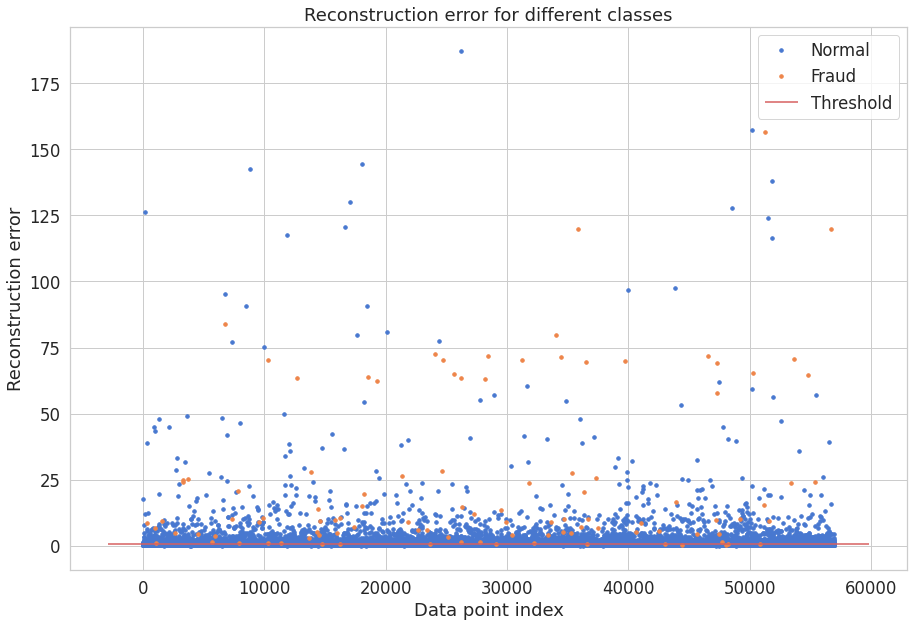

In [ ]:
# scatter plot
threshold = 0.9
groups = error_eig_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(15, 10))
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### (2) Confusion Matrix

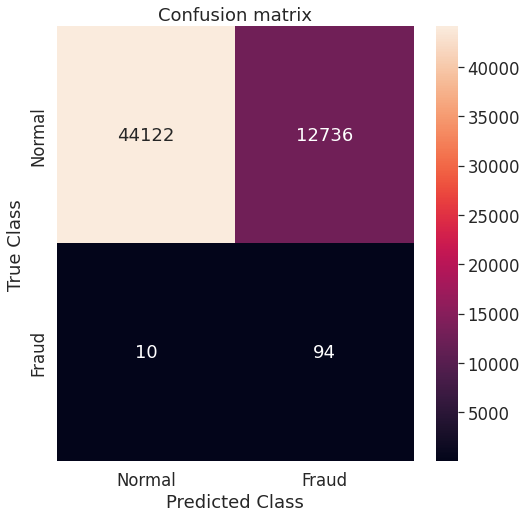

In [ ]:
# confusion matrix
threshold = 0.9
# And see how well we're dividing the two types of transactions:
groups = error_eig_df.groupby('true_class')
# predict fraud
y_pred = [1 if e > threshold else 0 for e in error_eig_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_eig_df.true_class, y_pred)
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### (3) ROC Curve

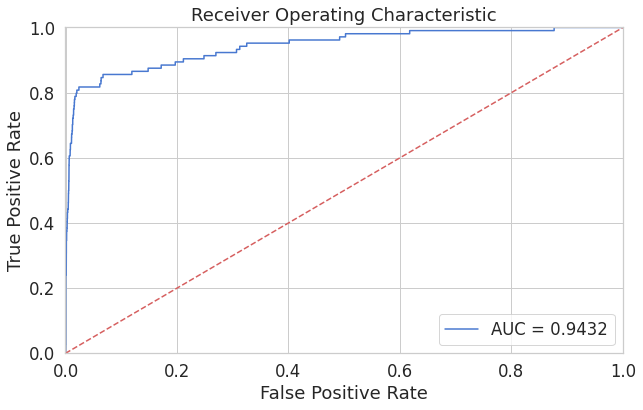

In [ ]:
# ROC
fpr, tpr, thresholds = roc_curve(error_eig_df.true_class, error_eig_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();